In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
HEATWAVE_THRESHOLD = 42.0
RISK_CONFIDENCE = 0.5

print(f" Heatwave Threshold = {HEATWAVE_THRESHOLD}°C")

 Heatwave Threshold = 42.0°C


In [3]:
df = pd.read_csv("df_hot.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').drop_duplicates('datetime')

In [4]:
df['month'] = df['datetime'].dt.month
df_summer = df[df['month'].isin([4, 5, 6])].copy()

In [5]:
df_summer['heatwave'] = (df_summer['tempmax'] >= HEATWAVE_THRESHOLD).astype(int)
hw_count = df_summer['heatwave'].sum()
print(f"Historical Heatwave Days (AMJ only): {hw_count}")

Historical Heatwave Days (AMJ only): 216


In [6]:
df_summer['day_of_year'] = df_summer['datetime'].dt.dayofyear
features = ['day_of_year', 'humidity', 'windspeed', 'precip', 'cloudcover']
features = [f for f in features if f in df_summer.columns]

X = df_summer[features]
y = df_summer['heatwave']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=300, max_depth=8, class_weight='balanced', random_state=42))
])


In [9]:
rf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If 

In [10]:
svc_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=5, gamma='scale', probability=True, class_weight='balanced', random_state=42))
])

In [11]:
svc_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If 

In [12]:
rf_pred = rf_pipeline.predict(X_test)
svc_pred = svc_pipeline.predict(X_test)

In [13]:
rf_acc = accuracy_score(y_test, rf_pred)
svc_acc = accuracy_score(y_test, svc_pred)

print(" MODEL EVALUATION REPORT")
print(f"Random Forest Accuracy: {rf_acc:.2%}")
print(f"SVM Accuracy:           {svc_acc:.2%}")
print("-" * 30)
print("Detailed Classification Report (RF):")
print(classification_report(y_test, rf_pred))



 MODEL EVALUATION REPORT
Random Forest Accuracy: 86.45%
SVM Accuracy:           76.17%
------------------------------
Detailed Classification Report (RF):
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       171
           1       0.65      0.72      0.68        43

    accuracy                           0.86       214
   macro avg       0.79      0.81      0.80       214
weighted avg       0.87      0.86      0.87       214



In [14]:
print("\nRetraining models on full historical dataset for future predictions...")
rf_pipeline.fit(X, y)
svc_pipeline.fit(X, y)
print(" Models ready for 2026 predictions.")


Retraining models on full historical dataset for future predictions...
 Models ready for 2026 predictions.


In [15]:
future_dates = pd.date_range("2026-04-01", "2026-06-30", freq="D")
future_df = pd.DataFrame({'datetime': future_dates})
future_df['day_of_year'] = future_df['datetime'].dt.dayofyear

climatology = df_summer.groupby('day_of_year')[features[1:]].mean().reset_index()
future_df = future_df.merge(climatology, on='day_of_year', how='left')
future_df.fillna(method='ffill', inplace=True)
future_df.fillna(method='bfill', inplace=True)

In [16]:
future_df['rf_prob'] = rf_pipeline.predict_proba(future_df[features])[:, 1]
future_df['svc_prob'] = svc_pipeline.predict_proba(future_df[features])[:, 1]
future_df['ensemble_prob'] = (future_df['rf_prob'] + future_df['svc_prob']) / 2


In [17]:
predicted_days = (future_df['ensemble_prob'] >= RISK_CONFIDENCE).sum()

print(f"RESULTS FOR THRESHOLD {HEATWAVE_THRESHOLD}°C")
print(f"Predicted Heatwave Days (Apr–Jun 2026): {predicted_days}")

if predicted_days > 0:
    print("\nPredicted Heatwave Dates:")
    print(future_df.loc[future_df['ensemble_prob'] >= RISK_CONFIDENCE, 'datetime'].dt.date.tolist())
else:
    moderate = (future_df['ensemble_prob'] >= 0.4).sum()
    print(f"No high-risk days (>50%). {moderate} days show moderate risk (>40%).")


RESULTS FOR THRESHOLD 42.0°C
Predicted Heatwave Days (Apr–Jun 2026): 15

Predicted Heatwave Dates:
[datetime.date(2026, 5, 1), datetime.date(2026, 5, 9), datetime.date(2026, 5, 10), datetime.date(2026, 5, 16), datetime.date(2026, 5, 18), datetime.date(2026, 5, 20), datetime.date(2026, 5, 21), datetime.date(2026, 5, 22), datetime.date(2026, 5, 23), datetime.date(2026, 5, 27), datetime.date(2026, 5, 28), datetime.date(2026, 5, 29), datetime.date(2026, 6, 5), datetime.date(2026, 6, 6), datetime.date(2026, 6, 10)]


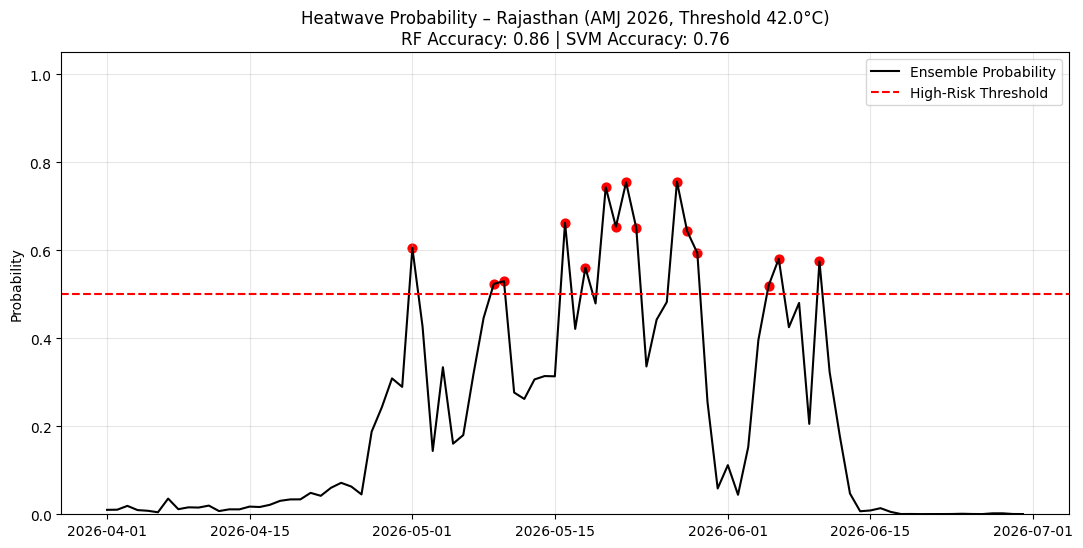

In [18]:
plt.figure(figsize=(13, 6))
plt.plot(future_df['datetime'], future_df['ensemble_prob'], label='Ensemble Probability', color='black')
plt.axhline(RISK_CONFIDENCE, color='red', linestyle='--', label='High-Risk Threshold')
risk_pts = future_df[future_df['ensemble_prob'] >= RISK_CONFIDENCE]
plt.scatter(risk_pts['datetime'], risk_pts['ensemble_prob'], color='red', s=40)
plt.title(f"Heatwave Probability – Rajasthan (AMJ 2026, Threshold {HEATWAVE_THRESHOLD}°C)\nRF Accuracy: {rf_acc:.2f} | SVM Accuracy: {svc_acc:.2f}")
plt.ylabel("Probability")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()